In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Историческая справка

- **Name** (Название):
	Название проекта.
-	**Deadline** (Крайний срок):
	Дата, до которой нужно собрать деньги.
-	**Goal** (Цель):
	Сумма, которую нужно собрать для проекта.
-	**Pledged** (Собрано):
	Сумма, которую уже внесли спонсоры.
-	**State** (Состояние):
	Текущее состояние проекта.
-	**Country** (Страна):
	Страна, откуда собраны деньги.
### Сгенерированные данные

- **usd_pledged** (Собрано в долларах США): Конвертация столбца “Собрано” в доллары США (конвертация выполнена платформой Kickstarter).
- **usd_pledged_real** (Собрано в долларах США, реальное): Конвертация столбца “Собрано” в доллары США (конвертация выполнена через API Fixer.io).
- **usd_goal_real** (Цель в долларах США, реальная): Конвертация столбца “Цель” в доллары США (конвертация выполнена через API Fixer.io).

### Прогнозы
- **state** (состояние): Успех или провал (два варианта) или несколько вариантов.
- **usd_pledged_real** Собранная сумма денег

## Первые шаги с данными


Удалить колонки ID и goal.
- Если currency == USD, использовать usd_pledged_real как pledged.
- Если currency != USD, использовать usd_pledged_real вместо usd_pledged.
- Вычислить продолжительность (dt) как разницу между launch и deadline.
- Удалить launch, если он не нужен, или преобразовать его, если потребуется.

In [3]:
df.shape[0] - df['ID'].nunique()

0

In [4]:
df[(df['usd pledged'] != df['usd_pledged_real']) & (df['currency'] == 'USD')][['pledged', 'usd pledged', 'usd_pledged_real']].head()

,pledged,usd pledged,usd_pledged_real
1,2421.00,100.0,2421.00
29,57577.31,10120.0,57577.31
31,47266.00,11253.0,47266.00
41,2100.00,83.0,2100.00
43,856.00,324.0,856.00


In [5]:
df[(df['usd pledged'] != df['usd_pledged_real']) & (df['currency'] != 'USD')][['pledged', 'usd pledged', 'usd_pledged_real', 'currency']].head()

,pledged,usd pledged,usd_pledged_real,currency
14,94175.00,57763.78,121857.33,GBP
21,1.00,0.00,0.81,AUD
23,48.00,6.18,6.29,NOK
27,48905.00,43203.25,42174.03,CAD
28,112.38,167.70,160.60,GBP


In [6]:
df[['pledged', 'usd pledged', 'usd_pledged_real']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   pledged           378661 non-null  float64
 1   usd pledged       374864 non-null  float64
 2   usd_pledged_real  378661 non-null  float64
dtypes: float64(3)
memory usage: 8.7 MB


In [7]:
df.drop(columns=['ID', 'goal', 'pledged', 'usd pledged'], inplace=True)

In [8]:
df.dtypes

name                 object
category             object
main_category        object
currency             object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

**launched** and **deadline** должны быть `datetime`

**category**, **main_category**, **state**, **country** могут быть преобразованы в категориальные данные

In [9]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

df['dt'] = (df['deadline'] - df['launched']).dt.days
df.drop(columns=['launched', 'deadline'], inplace=True)

In [10]:
obj_cols = df.columns[df.dtypes == 'object']
df[obj_cols].nunique()

name             375764
category            159
main_category        15
currency             14
state                 6
country              23
dtype: int64

In [11]:
df['state_ok'] = ((df['state'] == 'successful') | (df['state'] == 'live'))

main_category


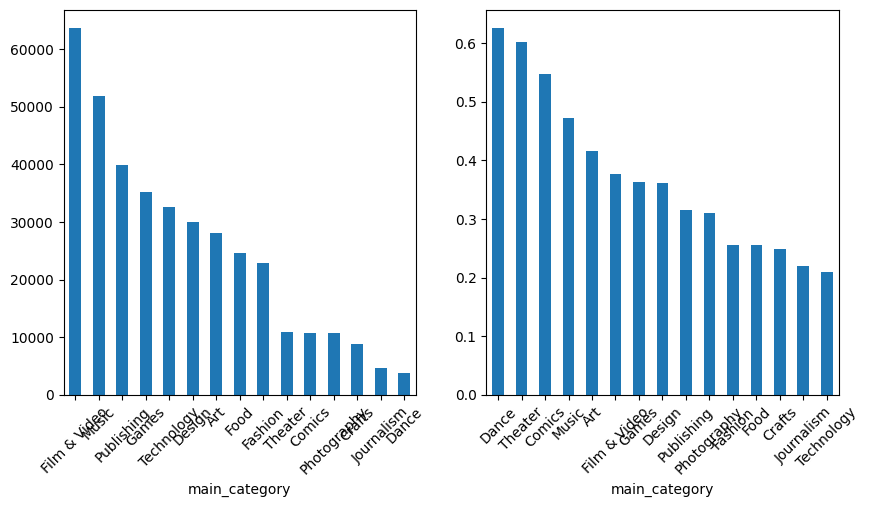

currency


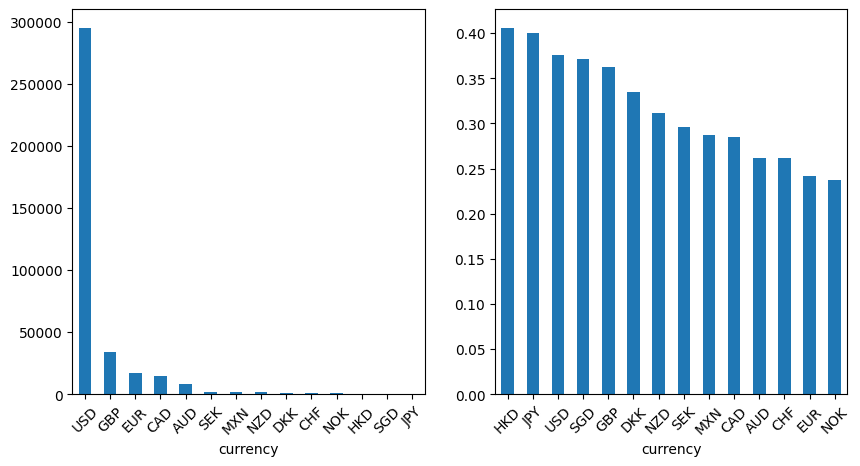

state


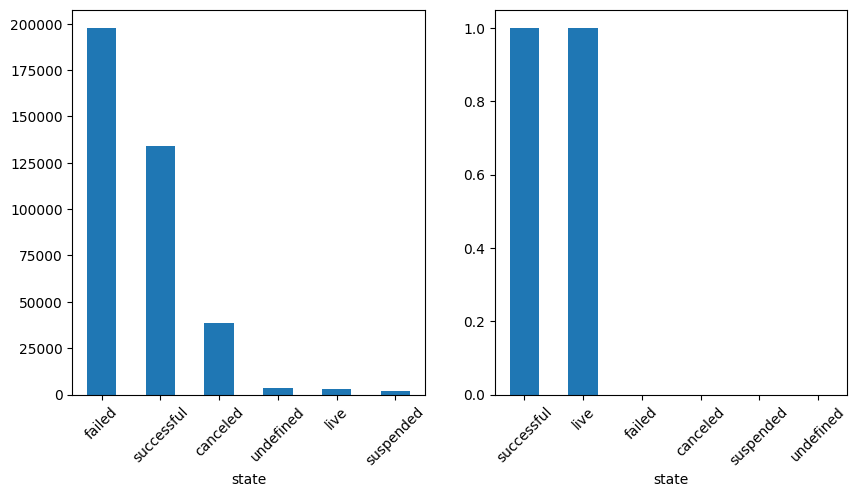

country


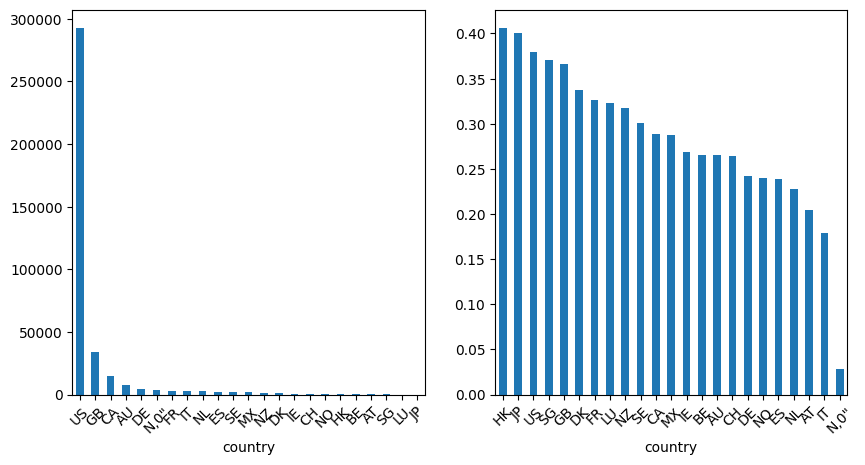

In [12]:
for cat_col in obj_cols[df[obj_cols].nunique() < 50]:
    print(cat_col)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    df[cat_col].value_counts().sort_values(ascending=False).plot.bar(rot=45, ax=axs[0])
    df.groupby(by=cat_col)['state_ok'].mean().sort_values(ascending=False).plot.bar(rot=45, ax=axs[1])

    plt.show()

- main_category: ok category
- category: drop or keywords (bag of words)
- у currency явной корреляции нет, так что можно склеить редкие в одну
- state для упрощения тоже можно бинаризовать, но это целевая переменная, так что может и не надо
- есть вероятность, что name будет не на английском, где country не USA

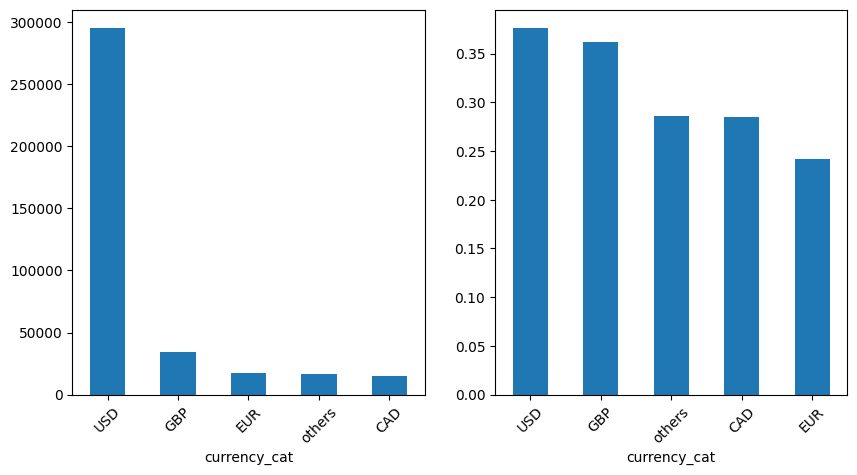

In [13]:
cat_col = 'currency_cat'

main_cats = ['USD', 'GBP', 'EUR', 'CAD']
df[cat_col] = df['currency'].apply(lambda x: x if x in main_cats else 'others')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

df[cat_col].value_counts().sort_values(ascending=False).plot.bar(rot=45, ax=axs[0])
df.groupby(by=cat_col)['state_ok'].mean().sort_values(ascending=False).plot.bar(rot=45, ax=axs[1])

plt.show()

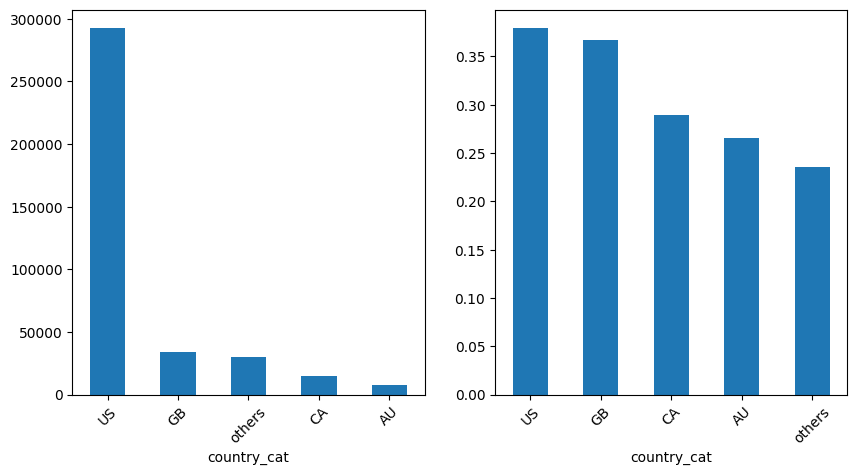

In [14]:
cat_col = 'country_cat'

main_cats = ['US', 'GB', 'CA', 'AU'] # may be without AU
df[cat_col] = df['country'].apply(lambda x: x if x in main_cats else 'others')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df[cat_col].value_counts().sort_values(ascending=False).plot.bar(rot=45, ax=axs[0])
df.groupby(by=cat_col)['state_ok'].mean().sort_values(ascending=False).plot.bar(rot=45, ax=axs[1])

plt.show()

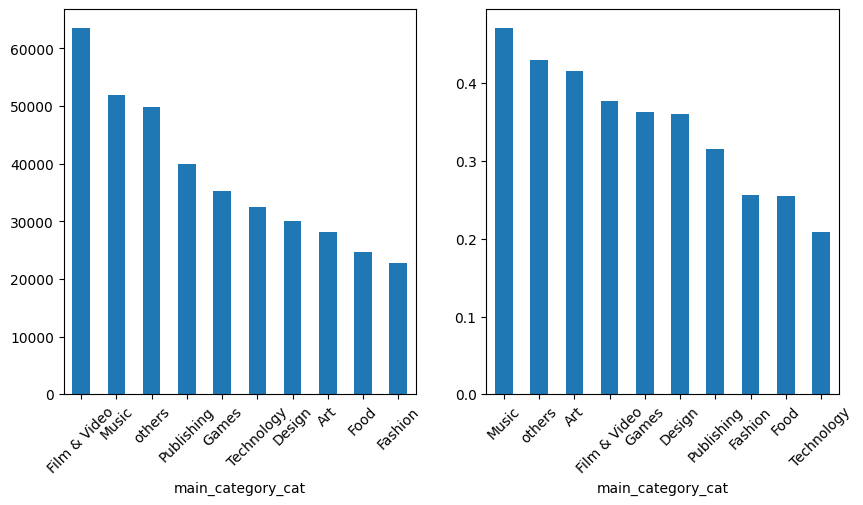

In [15]:
cat_col = 'main_category_cat'

main_cats = df['main_category'].value_counts().sort_values(ascending=False).index[:9]
df[cat_col] = df['main_category'].apply(lambda x: x if x in main_cats else 'others')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df[cat_col].value_counts().sort_values(ascending=False).plot.bar(rot=45, ax=axs[0])
df.groupby(by=cat_col)['state_ok'].mean().sort_values(ascending=False).plot.bar(rot=45, ax=axs[1])

plt.show()

In [16]:
df['main_category_cat'] = df['main_category_cat'].astype('category')
df['currency_cat'] = df['currency_cat'].astype('category')
df['country_cat'] = df['country_cat'].astype('category')
df['state'] = df['state'].astype('category')

In [17]:
df.drop(columns=['main_category', 'currency', 'country'], inplace=True)

In [18]:
df.dtypes

name                   object
category               object
state                category
backers                 int64
usd_pledged_real      float64
usd_goal_real         float64
dt                      int64
state_ok                 bool
currency_cat         category
country_cat          category
main_category_cat    category
dtype: object

С типами ОК

In [19]:
num_cols = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]

<Axes: >

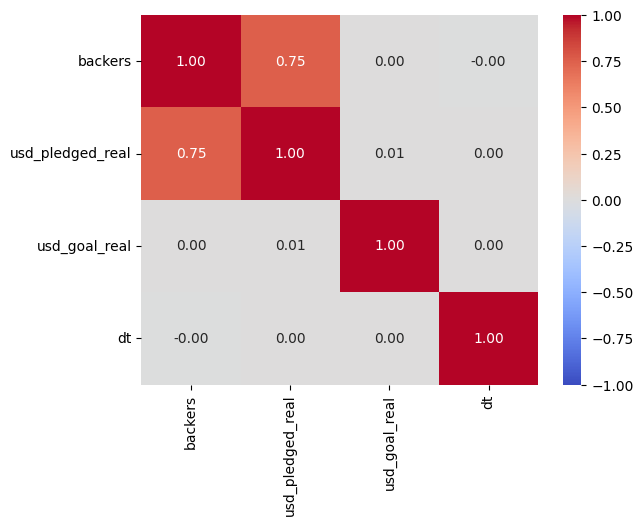

In [20]:
sns.heatmap(df[num_cols].corr(), fmt='.2f', vmin=-1, annot=True, cmap='coolwarm')

In [21]:
df[num_cols].describe()

,backers,usd_pledged_real,usd_goal_real,dt
count,378661.000000,3.786610e+05,3.786610e+05,378661.000000
mean,105.617476,9.058924e+03,4.545440e+04,33.481122
std,907.185035,9.097334e+04,1.152950e+06,65.909172
min,0.000000,0.000000e+00,1.000000e-02,0.000000
25%,2.000000,3.100000e+01,2.000000e+03,29.000000
50%,12.000000,6.243300e+02,5.500000e+03,29.000000
75%,56.000000,4.050000e+03,1.550000e+04,36.000000
max,219382.000000,2.033899e+07,1.663614e+08,16738.000000


- **bakers** и **usd_pledged_real** сильно коррелированны, остальные совсем нет
- во всех признаках есть выбросы

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   name               378657 non-null  object  
 1   category           378661 non-null  object  
 2   state              378661 non-null  category
 3   backers            378661 non-null  int64   
 4   usd_pledged_real   378661 non-null  float64 
 5   usd_goal_real      378661 non-null  float64 
 6   dt                 378661 non-null  int64   
 7   state_ok           378661 non-null  bool    
 8   currency_cat       378661 non-null  category
 9   country_cat        378661 non-null  category
 10  main_category_cat  378661 non-null  category
dtypes: bool(1), category(4), float64(2), int64(2), object(2)
memory usage: 19.1+ MB


## Пропуски

In [23]:
df[df.isna().sum(axis=1) > 0]

,name,category,state,backers,usd_pledged_real,usd_goal_real,dt,state_ok,currency_cat,country_cat,main_category_cat
166851,NaN,Narrative Film,failed,1,100.00,200000.00,58,False,USD,US,Film & Video
307234,NaN,Video Games,failed,12,316.05,3224.97,17,False,GBP,GB,Games
309991,NaN,Product Design,suspended,0,0.00,2500.00,29,False,USD,US,Design
338931,NaN,Painting,failed,5,220.00,35000.00,28,False,USD,US,Art


In [24]:
df.dropna(inplace=True)

## Выбросы

<Axes: >

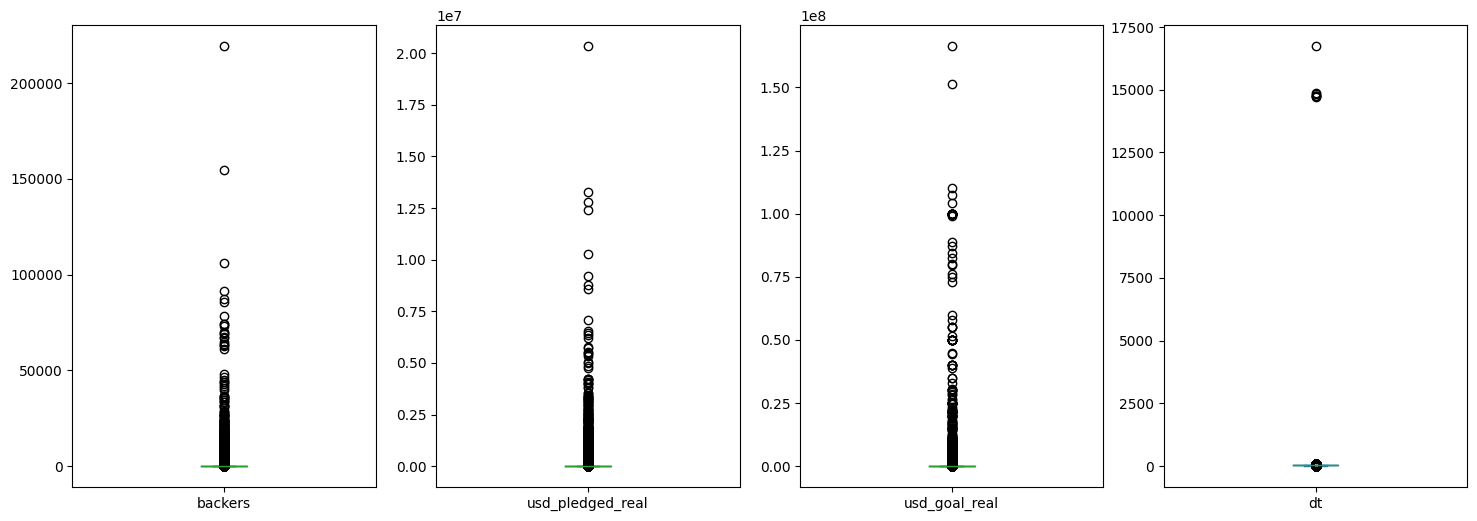

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
df['backers'].plot(kind='box', ax=axs[0])
df['usd_pledged_real'].plot(kind='box', ax=axs[1])
df['usd_goal_real'].plot(kind='box', ax=axs[2])
df['dt'].plot(kind='box', ax=axs[3])

In [26]:
data1 = df[
    (df['backers'] >= df['backers'].quantile(0.005)) & (df['backers'] <= df['backers'].quantile(0.995)) &
    (df['usd_pledged_real'] >= df['usd_pledged_real'].quantile(0.005)) & (df['usd_pledged_real'] <= df['usd_pledged_real'].quantile(0.995)) &
    (df['usd_goal_real']  >= df['usd_goal_real'].quantile(0.005)) & (df['usd_goal_real']  <= df['usd_goal_real'].quantile(0.995)) &
    (df['dt']  >= df['dt'].quantile(0.005)) & (df['dt']  <= df['dt'].quantile(0.995))]
data1.shape

(370353, 11)

In [27]:
Q1, Q3 = df['backers'].quantile([.25, .75])
IQR = Q3 - Q1
backers_L = Q1 - 1.5*IQR
backers_U = Q3 + 1.5*IQR

Q1, Q3 = df['usd_pledged_real'].quantile([.25, .75])
IQR = Q3 - Q1
pledged_L = Q1 - 1.5*IQR
pledged_U = Q3 + 1.5*IQR

Q1, Q3 = df['usd_goal_real'].quantile([.25, .75])
IQR = Q3 - Q1
goal_L = Q1 - 1.5*IQR
goal_U = Q3 + 1.5*IQR

Q1, Q3 = df['dt'].quantile([.25, .75])
IQR = Q3 - Q1
dt_L = Q1 - 1.5*IQR
dt_U = Q3 + 1.5*IQR

In [28]:
data2 = df[
    (df['backers'] >= backers_L) & (df['backers'] <= backers_U) &
    (df['usd_pledged_real'] >= pledged_L) & (df['usd_pledged_real'] <= pledged_U) &
    (df['usd_goal_real']  >= goal_L) & (df['usd_goal_real']  <= goal_U) &
    (df['dt']  >= dt_L) & (df['dt']  <= dt_U)]
data2.shape

(223647, 11)

In [29]:
data3 = df[(((df[num_cols] - df[num_cols].mean()) / df[num_cols].std()).abs() < 1).all(axis=1)]
data3.shape

(370181, 11)

<Axes: xlabel='dt', ylabel='usd_pledged_real'>

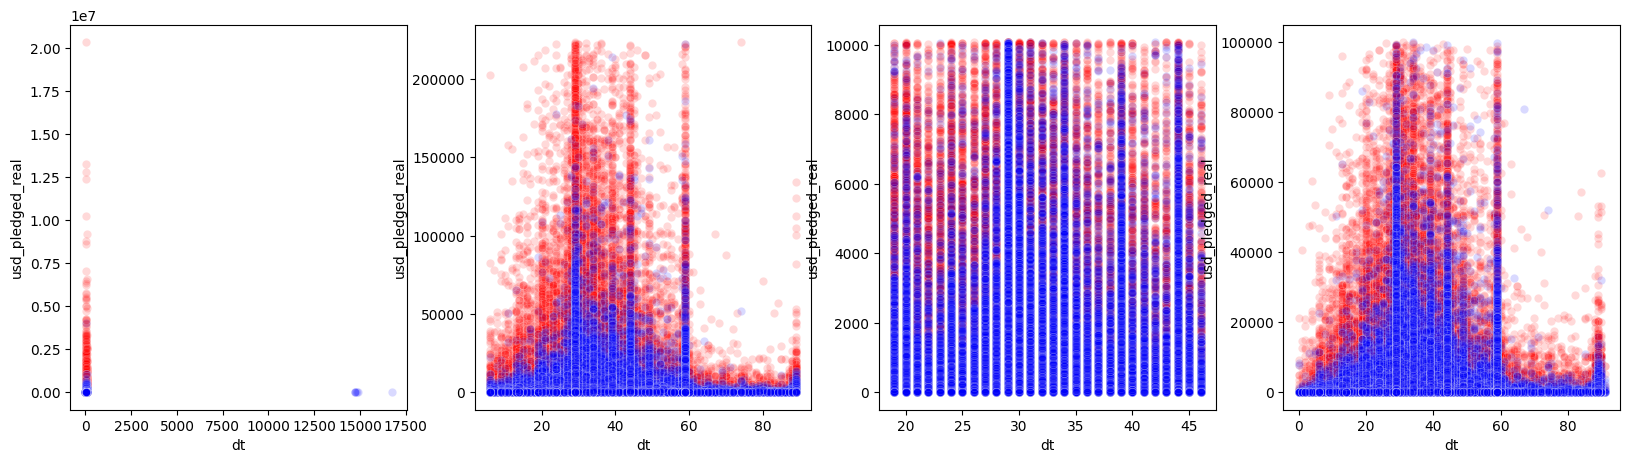

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.scatterplot(x='dt', y='usd_pledged_real', data=df[df['state_ok'] == True], color='r', alpha=0.15, ax=axs[0])
sns.scatterplot(x='dt', y='usd_pledged_real', data=df[df['state_ok'] == False], color='b', alpha=0.15, ax=axs[0])

sns.scatterplot(x='dt', y='usd_pledged_real', data=data1[data1['state_ok'] == True], color='r', alpha=0.15, ax=axs[1])
sns.scatterplot(x='dt', y='usd_pledged_real', data=data1[data1['state_ok'] == False], color='b', alpha=0.15, ax=axs[1])

sns.scatterplot(x='dt', y='usd_pledged_real', data=data2[data2['state_ok'] == True], color='r', alpha=0.15, ax=axs[2])
sns.scatterplot(x='dt', y='usd_pledged_real', data=data2[data2['state_ok'] == False], color='b', alpha=0.15, ax=axs[2])

sns.scatterplot(x='dt', y='usd_pledged_real', data=data3[data3['state_ok'] == True], color='r', alpha=0.15, ax=axs[3])
sns.scatterplot(x='dt', y='usd_pledged_real', data=data3[data3['state_ok'] == False], color='b', alpha=0.15, ax=axs[3])

<Axes: xlabel='backers', ylabel='usd_pledged_real'>

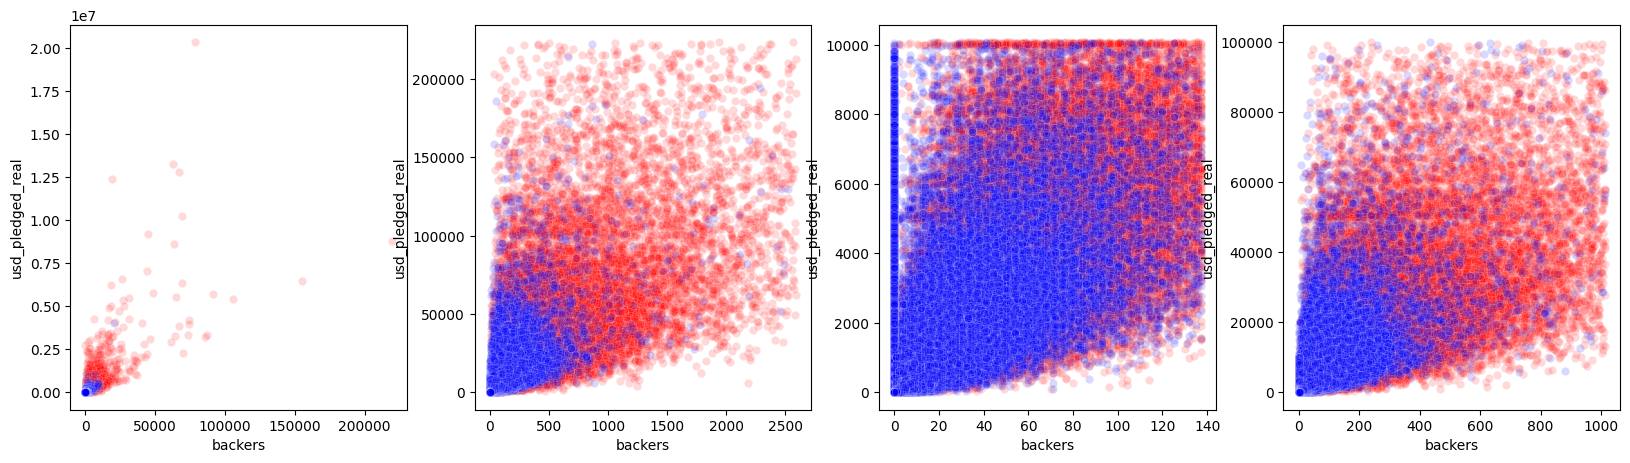

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

sns.scatterplot(x='backers', y='usd_pledged_real', data=df[df['state_ok'] == True], color='r', alpha=0.15, ax=axs[0])
sns.scatterplot(x='backers', y='usd_pledged_real', data=df[df['state_ok'] == False], color='b', alpha=0.15, ax=axs[0])

sns.scatterplot(x='backers', y='usd_pledged_real', data=data1[data1['state_ok'] == True], color='r', alpha=0.15, ax=axs[1])
sns.scatterplot(x='backers', y='usd_pledged_real', data=data1[data1['state_ok'] == False], color='b', alpha=0.15, ax=axs[1])

sns.scatterplot(x='backers', y='usd_pledged_real', data=data2[data2['state_ok'] == True], color='r', alpha=0.15, ax=axs[2])
sns.scatterplot(x='backers', y='usd_pledged_real', data=data2[data2['state_ok'] == False], color='b', alpha=0.15, ax=axs[2])

sns.scatterplot(x='backers', y='usd_pledged_real', data=data3[data3['state_ok'] == True], color='r', alpha=0.15, ax=axs[3])
sns.scatterplot(x='backers', y='usd_pledged_real', data=data3[data3['state_ok'] == False], color='b', alpha=0.15, ax=axs[3])

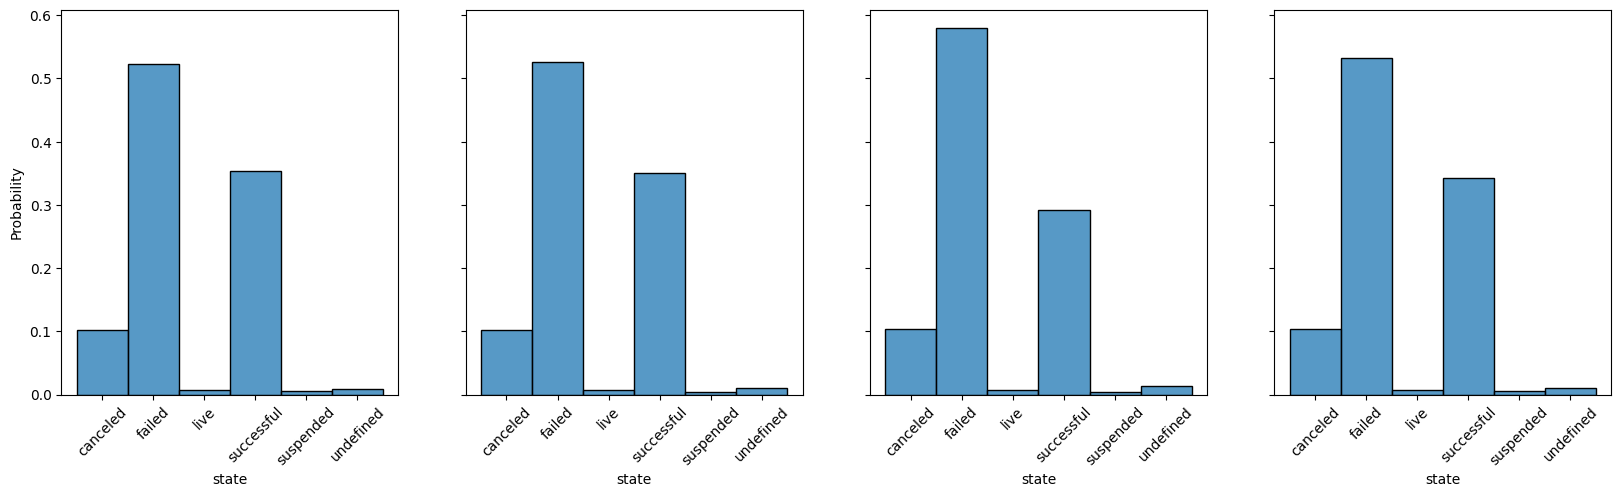

In [32]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

sns.histplot(df['state'], stat='probability', ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
sns.histplot(data1['state'], stat='probability', ax=axs[1])
axs[1].tick_params(axis='x', rotation=45)
sns.histplot(data2['state'], stat='probability', ax=axs[2])
axs[2].tick_params(axis='x', rotation=45)
sns.histplot(data3['state'], stat='probability', ax=axs[3])
axs[3].tick_params(axis='x', rotation=45)

`data1` не достаточно хорошо удаляет выбросы, но сохраняет распределение `state`

Видно, что среди выбросов `data2` много успешных проектов. Поэтому выбросы можно не удалять, а использовать деревья решений

Поэтому для визуализации зависимостей и каких-нибудь линейных моделей больше подходит `data2`, а для деревьев можно использовать `data1`. Проверим это

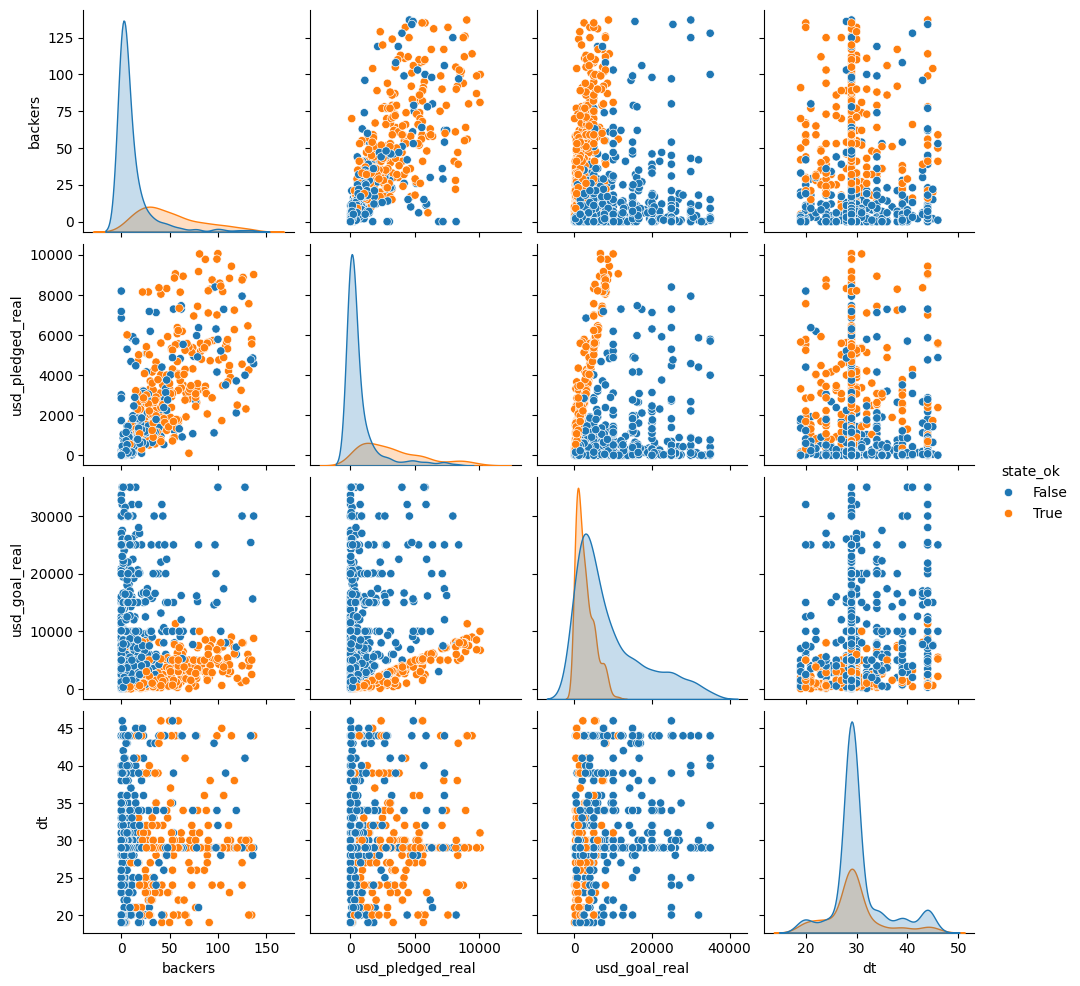

In [33]:
sns.pairplot(data2.sample(1000), hue='state_ok')

In [34]:
df.head()

,name,category,state,backers,usd_pledged_real,usd_goal_real,dt,state_ok,currency_cat,country_cat,main_category_cat
0,The Songs of Adelaide & Abullah,Poetry,failed,0,0.0,1533.95,58,False,GBP,GB,Publishing
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,failed,15,2421.0,30000.00,59,False,USD,US,Film & Video
2,Where is Hank?,Narrative Film,failed,3,220.0,45000.00,44,False,USD,US,Film & Video
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,failed,1,1.0,5000.00,29,False,USD,US,Music
4,Community Film Project: The Art of Neighborhoo...,Film & Video,canceled,14,1283.0,19500.00,55,False,USD,US,Film & Video


## Регрессия

### Sol 1

In [35]:
tbls = {
    'df': pd.DataFrame(index=['RMSE_train', 'RMSE_test', 'R2_train', 'R2_test']),
    'data1': pd.DataFrame(index=['RMSE_train', 'RMSE_test', 'R2_train', 'R2_test']),
    'data2': pd.DataFrame(index=['RMSE_train', 'RMSE_test', 'R2_train', 'R2_test']),
    'data3': pd.DataFrame(index=['RMSE_train', 'RMSE_test', 'R2_train', 'R2_test']),
}

In [36]:
cat_data = df[['main_category_cat', 'currency_cat', 'country_cat']]
cat_data.describe()

,main_category_cat,currency_cat,country_cat
count,378657,378657,378657
unique,10,5,5
top,Film & Video,USD,US
freq,63584,295362,292624


In [37]:
dummies = pd.get_dummies(cat_data)
dummies

,main_category_cat_Art,main_category_cat_Design,main_category_cat_Fashion,main_category_cat_Film & Video,main_category_cat_Food,main_category_cat_Games,main_category_cat_Music,main_category_cat_Publishing,main_category_cat_Technology,main_category_cat_others,currency_cat_CAD,currency_cat_EUR,currency_cat_GBP,currency_cat_USD,currency_cat_others,country_cat_AU,country_cat_CA,country_cat_GB,country_cat_US,country_cat_others
0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
378657,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
378658,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
378659,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False


In [38]:
data_name = 'data3'
tbl = tbls[data_name]
data = eval(data_name)

d = pd.concat(
    (
        data[['usd_pledged_real', 'backers', 'usd_goal_real', 'dt']],
        pd.get_dummies(data[['main_category_cat', 'currency_cat', 'country_cat']])
    ),
    axis=1).drop_duplicates()
X = d.drop('usd_pledged_real', axis=1)
y = d['usd_pledged_real']
X.shape, y.mean()

((331834, 23), np.float64(4612.68026808585))

In [39]:
bdt = X.columns[X.dtypes == 'bool']
X[bdt] = X[bdt].astype('int64')

<Axes: >

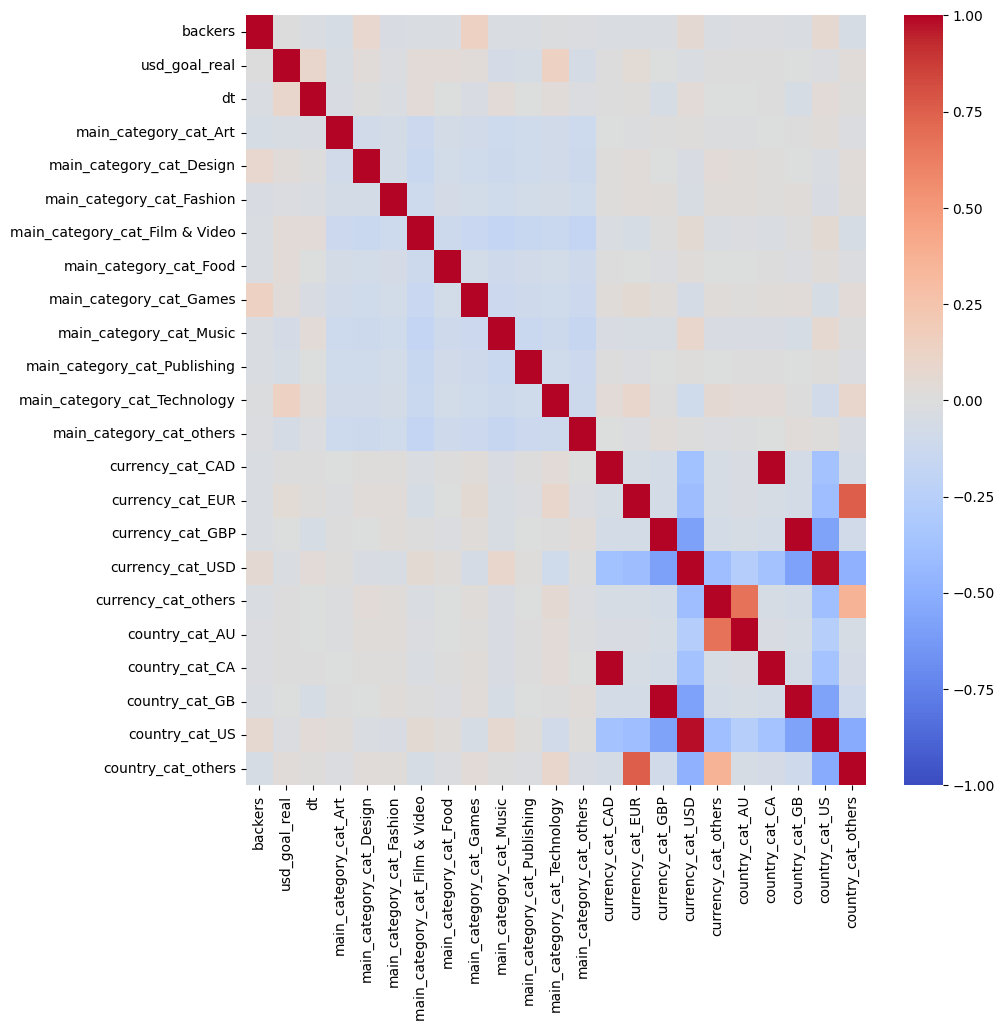

In [40]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), fmt='.2f', vmin=-1, cmap='coolwarm')

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [43]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

tbl['Lin'] = RMSE_train, RMSE_test, R2_train, R2_test

RMSE_train, RMSE_test, R2_train, R2_test

(6223.908391547389, 6126.713823365826, 0.6059656224551508, 0.6091433861125892)

In [46]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [47]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [48]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

tbl['KN'] = RMSE_train, RMSE_test, R2_train, R2_test

RMSE_train, RMSE_test, R2_train, R2_test

(4529.031422999219, 5132.861813171497, 0.7913499957882031, 0.7256648731096389)

In [49]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [51]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

tbl['RnF'] = RMSE_train, RMSE_test, R2_train, R2_test

RMSE_train, RMSE_test, R2_train, R2_test

(2031.9128037545975, 5018.179361167168, 0.9580030390939193, 0.7377867490352849)

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [53]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [54]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

tbl['GB'] = RMSE_train, RMSE_test, R2_train, R2_test

RMSE_train, RMSE_test, R2_train, R2_test

(4804.001627028967, 4714.5542841824645, 0.7652454482748108, 0.768557263065917)

In [55]:
tbls

{'df': Empty DataFrame
 Columns: []
 Index: [RMSE_train, RMSE_test, R2_train, R2_test],
 'data1': Empty DataFrame
 Columns: []
 Index: [RMSE_train, RMSE_test, R2_train, R2_test],
 'data2': Empty DataFrame
 Columns: []
 Index: [RMSE_train, RMSE_test, R2_train, R2_test],
 'data3':                     Lin           KN          RnF           GB
 RMSE_train  6223.908392  4529.031423  2031.912804  4804.001627
 RMSE_test   6126.713823  5132.861813  5018.179361  4714.554284
 R2_train       0.605966     0.791350     0.958003     0.765245
 R2_test        0.609143     0.725665     0.737787     0.768557}

In [56]:
param_grid = [
    {
        'n_estimators': [50, 100, 200],
        'subsample': [0.5, 0.7, 1.0],
        'max_depth': [3, 7, 9]
    }
]

from sklearn.model_selection import GridSearchCV, RepeatedKFold

gb = GradientBoostingRegressor()
gs = GridSearchCV(estimator=gb, param_grid=param_grid, n_jobs=-1, cv=3)

gs.fit(X_train, y_train)

gs.best_params_

CPU times: user 37.6 s, sys: 1.78 s, total: 39.4 s
Wall time: 14min 55s


{'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}

In [57]:
model = gs.best_estimator_

In [58]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [59]:
MSE_train = mean_squared_error(y_train, y_train_predict)
MSE_test  = mean_squared_error(y_test,  y_test_predict)
R2_train = r2_score(y_train, y_train_predict)
R2_test  = r2_score(y_test,  y_test_predict)
RMSE_train = (MSE_train)**(.5)
RMSE_test = (MSE_test)**(.5)

RMSE_train, RMSE_test, R2_train, R2_test

(4456.102264307551, 4663.7857553372505, 0.7980155072087616, 0.7735149925862964)

Результаты довольно противоречивые
- у `RandomForestRegressor` точно видим overfitting
- затюненый `GradientBoostingRegressor` имеет небольшой `n_estimators` и `subsample`=1 (что тоже косвенно указывает на overfit)

В целом R2 0.77 приемлемо, но из-за большого размера данных (0.3*1e6, 23) обучение довольно долгое, поэтому сложно

## Кластеризация (используем только X)

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [61]:
scaler = StandardScaler()
scaler.fit(X)

X_z = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
X_z.shape

(331834, 23)

In [ ]:
from time import time


loc_list = []
sil_list = []

n_clusters_list = list(range(2, 9))
feautures = X_z.sample(150000, random_state=47)
for k in n_clusters_list:
    t = time()
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feautures)

    loc_list.append(kmeans.inertia_)

    score = silhouette_score(feautures, kmeans.labels_)
    sil_list.append(score)
    print(k, time() - t)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.xlabel('Число кластеров')

axs[0].plot(n_clusters_list, loc_list, marker='o')
axs[0].set_ylabel('WCSS')

axs[1].plot(n_clusters_list, sil_list, marker='o')
axs[1].set_ylabel('Силуэтная оценка')

plt.show()

In [ ]:
feautures_30 = X_z.sample(30000, random_state=47)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(feautures_30)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(feautures_30)

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('KMeans Clustering')
plt.show()

In [ ]:
D_dict = feautures_30.apply(lambda x: silhouette_score(x.values.reshape(-1, 1), kmeans.labels_))

top = D_dict[D_dict > D_dict.quantile(0.9)]
top.sort_values()

In [ ]:
feautures_c = X.loc[feautures_30.index].assign(cluster_label=kmeans.labels_)
for i, (diff_label) in enumerate(top.index):
    print(diff_label, feautures_c[diff_label].mean(), feautures_c[diff_label].std())
    print(feautures_c.groupby('cluster_label')[diff_label].mean())
    print()

# Кластеризация 1
- Кластер 0 - оплата в USD, страна US
- Кластер 1 - оплата в GBP
- Кластер 2 - остальные
# Кластеризация 2
- Кластер 0 - остальные
- Кластер 1 - проекты по дизайну
- Кластер 2 - не оплата в USD, не страна US

In [ ]:
dbscan = DBSCAN(eps=7, min_samples=2)
dbscan.fit(feautures_30)

In [ ]:
feautures_c = X.loc[feautures_30.index].assign(cluster_label=dbscan.labels_ + 1)
for i, (diff_label) in enumerate(top.index):
    print(diff_label, feautures_c[diff_label].mean(), feautures_c[diff_label].std())
    print(feautures_c.groupby('cluster_label')[diff_label].mean())
    print()

# Кластеризация 2
- Кластер 0 - проекты не по дизайну
- Кластер 1 - остальные
- Кластер 2 - не оплата в USD, не страна US

у DBSCAN своя геометрия, поэтому силуэтная оценка может по другому интерпретировать результаты

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(feautures_30)

In [ ]:
feautures_c = X.loc[feautures_30.index].assign(cluster_label=hierarchical_labels)
for i, (diff_label) in enumerate(top.index):
    print(diff_label, feautures_c[diff_label].mean(), feautures_c[diff_label].std())
    print(feautures_c.groupby('cluster_label')[diff_label].mean())
    print()

# Кластеризация 2
- Кластер 0 - проекты по дизайну
- Кластер 1 - оплата в USD, страна US
- Кластер 2 - остальное

# Общие выводы из кластеризации
- Кластер 0 - проекты с оплатой в USD и из US
- Кластер 1 - остальные, но разделённые по другому признаку (например валюта GBP или категория Дизайн)
- Кластер 2 - остальные

То есть кластеризация имеет иерархический характер

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
feautures_1 = X_z.sample(1000, random_state=47)
linked = linkage(feautures_1, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.show()